In [4]:
""" This module implements the base function to implement a VQE for a Ising Chain with Transverse Field. """
import pennylane as qml
from pennylane import numpy as np
import numpy as onp
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

from matplotlib import pyplot as plt

import copy
import tqdm  # Pretty progress bars

import sys
sys.path.insert(0, '../')
import vqe as vqe
import annni_model as annni
import qcnnmix as qcnn
import visualization as qplt
import encoder as enc
import losses

In [5]:
path = '../data/vqes/ANNNI/'

In [6]:
N = 8
side = 30


In [8]:
myvqe = vqe.load_vqe(path+'N'+str(N)+'n'+str(side))


ModuleNotFoundError: No module named 'vqe2'

In [7]:
try:
    myvqe = vqe.load_vqe(path+'N'+str(N)+'n'+str(side))
except:
    print('VQE not found')

VQE not found


In [73]:
myqcnn = qcnn.qcnn(myvqe, qcnn.qcnn_circuit, n_outputs = 2)

In [74]:
train_index = np.arange(0,2*side-1)


In [75]:
@qml.qnode(myqcnn.device, interface="jax")
def qcnn_circuit_prob(vqe_p, qcnn_p):
    myqcnn.vqe_qcnn_circuit(vqe_p, qcnn_p)

    if myqcnn.n_outputs == 1:
        return qml.probs(wires=myqcnn.N - 1)
    else:
        return qml.probs([int(k) for k in myqcnn.final_active_wires])

In [76]:
circ = jax.vmap( lambda v: qcnn_circuit_prob(v, myqcnn.params) )

In [77]:
bbb = circ(myqcnn.vqe.vqe_params0)

In [ ]:
myqcnn.train(.5, 100000, train_index, cost, circuit=True)

59
+--- CIRCUIT ---+
0: ──||──||──RY(0.00)──RX(8.00)───||──RY(16.00)─────||──RY(20.00)─╭C──RY(25.00)──||
1: ──||──||──RY(1.00)──RX(9.00)───||──RY(16.00)─╭C──||──RY(21.00)─╰X──RY(26.00)──||
2: ──||──||──RY(2.00)──RX(10.00)──||──RY(17.00)─╰X──||──RY(21.00)─╭C──RY(27.00)──||
3: ──||──||──RY(3.00)──RX(11.00)──||──RY(17.00)─╭C──||──RY(22.00)─╰X──RY(28.00)──||
4: ──||──||──RY(4.00)──RX(12.00)──||──RY(18.00)─╰X──||──RY(22.00)─╭C──RY(29.00)──||
5: ──||──||──RY(5.00)──RX(13.00)──||──RY(18.00)─╭C──||──RY(23.00)─╰X──RY(30.00)──||
6: ──||──||──RY(6.00)──RX(14.00)──||──RY(19.00)─╰X──||──RY(23.00)─╭C──RY(31.00)──||
7: ──||──||──RY(7.00)──RX(15.00)──||──RY(19.00)─────||──RY(24.00)─╰X──RY(32.00)──||

──╭C──────────────────────────╭C──────────────────────────────────────||──||────────────────||
──╰ControlledOperation(33.00)─╰ControlledOperation(34.00)──RX(41.00)──||──||──RY(45.00)─────||
──╭C──────────────────────────╭C──────────────────────────────────────||──||────────────────||
──╰ControlledOperatio

Cost: 0.09243479371070862:  44%|███▌    | 43975/100000 [04:15<05:10, 180.53it/s]

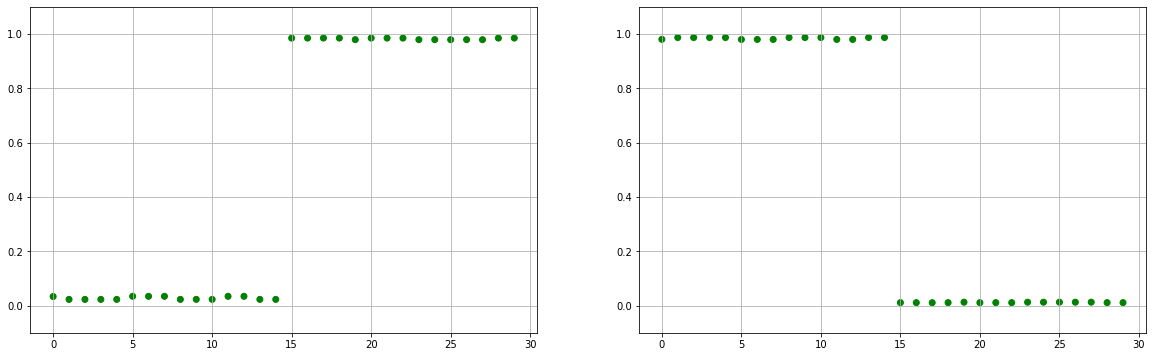

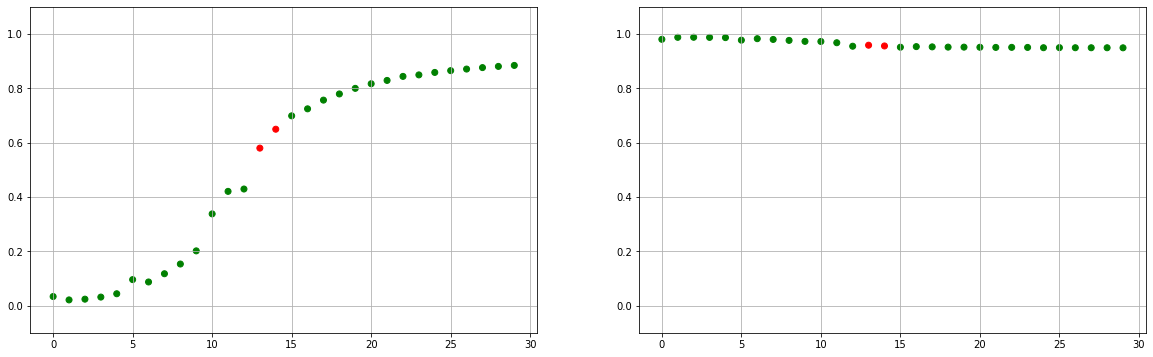

In [80]:
show_QCNN_classification2D(myqcnn)

In [81]:
def show_QCNN_classification2D(qcnnclass, inject = False):
    """
    Plots performance of the classifier on the whole data
    """
    circuit = qcnnclass.vqe_qcnn_circuit if inject == False else qcnnclass.psi_qcnn_circuit
    
    @qml.qnode(qcnnclass.device, interface="jax")
    def qcnn_circuit_prob(params_vqe, params):
        circuit(params_vqe, params)

        if qcnnclass.n_outputs == 1:
            return qml.probs(wires=self.N - 1)
        else:
            return [qml.probs(wires=int(k)) for k in qcnnclass.final_active_wires]
        
    mask1 = jnp.array(qcnnclass.vqe.Hs.model_params)[:,1] == 0
    mask2 = jnp.array(qcnnclass.vqe.Hs.model_params)[:,2] == 0

    ising_1, label_1  = qcnnclass.vqe_params[mask1], qcnnclass.labels[mask1,:].astype(int)
    ising_2, label_2  = qcnnclass.vqe_params[mask2], qcnnclass.labels[mask2,:].astype(int)

    vcircuit = jax.vmap(lambda v: qcnn_circuit_prob(v, qcnnclass.params), in_axes=(0))
    predictions1 = vcircuit(ising_1)
    predictions2 = vcircuit(ising_2)

    out1_p1, out2_p1, c1 = [], [], []
    for idx, pred in enumerate(predictions1):
        out1_p1.append(pred[0][1])
        out2_p1.append(pred[1][1])

        if (np.argmax(pred[0]) == label_1[idx][0]) and (np.argmax(pred[1]) == label_1[idx][1]):
            c1.append('green')
        else:
            c1.append('red')

    fig, ax = plt.subplots(1, 2, figsize=(20, 6))

    x = np.arange(int(np.sqrt(qcnnclass.n_states)))
    ax[0].grid(True)
    ax[0].scatter(x, out1_p1, c=c1)
    ax[0].set_ylim(-.1,1.1)
    ax[1].grid(True)
    ax[1].scatter(x, out2_p1, c=c1)
    ax[1].set_ylim(-.1,1.1)

    plt.show()

    out1_p2, out2_p2, c2 = [], [], []
    for idx, pred in enumerate(predictions2):
        out1_p2.append(pred[0][1])
        out2_p2.append(pred[1][1])

        if (np.argmax(pred[0]) == label_2[idx][0]) and (np.argmax(pred[1]) == label_2[idx][1]):
            c2.append('green')
        else:
            c2.append('red')

    fig, ax = plt.subplots(1, 2, figsize=(20, 6))

    x = np.arange(int(np.sqrt(qcnnclass.n_states)))
    ax[0].grid(True)
    ax[0].scatter(x, out1_p2, c=c2)
    ax[0].set_ylim(-.1,1.1)
    ax[1].grid(True)
    ax[1].scatter(x, out2_p2, c=c2)
    ax[1].set_ylim(-.1,1.1)

    plt.show()

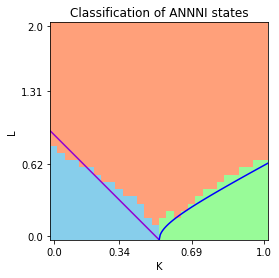

In [82]:
qplt.show_QCNN_classificationANNNI(myqcnn, hard_thr = True)

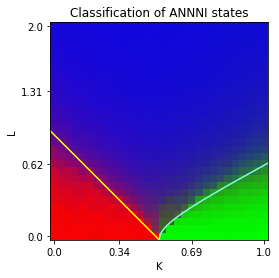

In [83]:
qplt.show_QCNN_classificationANNNI(myqcnn, hard_thr = False)